<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/m_EasyOCR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EasyOCR

## Packages

In [2]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 26 kB/s 
     |████████████████████████████████| 47.6 MB 98 kB/s 


In [58]:
import easyocr
import os
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!cp drive/MyDrive/Colab_Notebooks/VU/utils.py .
from utils import *

## Setup

In [6]:
# if GPU is to be used, allow CUDA
use_GPU = True  # False

## Dataset loading

### CTW1500 dataset

 - testing set (500 images)

Get images. Update location of images **manually**.

Comment if not using CTW1500 dataset.

In [269]:
# whether images are to be resized (skrinking)
resize = True
width = 3000

# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_images'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
                        
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# Get paths to files with labels. Update location manually
# path to label directory, get full path to all files
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]

# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in enumerate(list_xml_paths):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_ctw_test(file, scaling_ratio=ratio))
else:
    for i, file in enumerate(list_xml_paths):
        ground_truth.append(read_gt_ctw_test(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

### KAISTdetectiondataset

In [234]:
# path to image and label directory, get full path to all files
directory = '/content/drive/MyDrive/Colab_Notebooks/VU/Kaist'

list_img_paths = []
list_bmp_paths = []
list_xml_paths = []
filenames = []
for path, dirs, files in os.walk(directory):
    for file in files:
        if(file.endswith(".jpg") or file.endswith(".JPG") ):
            list_img_paths.append(os.path.join(path, file))
            list_img_paths.sort()
            filenames.append(file)
        if(file.endswith(".bmp")):
            list_bmp_paths.append(os.path.join(path, file))
            list_bmp_paths.sort()
        if(file.endswith(".xml")):
            list_xml_paths.append(os.path.join(path, file))
            list_xml_paths.sort()


n_imgs = len(list_img_paths)
n_bmps = len(list_bmp_paths)
n_labels = len(list_xml_paths)

assert n_imgs == n_labels, "Check both xml and image files"

# whether images are to be resized (skrinking)
resize = False
width = 3000

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]

# from already text detected images, which are provided in Kaist dataset
# original_images = [(cv.imread(file)) for file in list_bmp_paths]
  
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_kaist(file, scaling_ratio=ratio))
else:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ground_truth.append(read_gt_kaist(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

395it [00:00, 930.00it/s]


In [235]:
import xml.etree.ElementTree as ET
import numpy as np

def read_gt_kaist(xml_file, scaling_ratio=1):
    """
    KAISTdetectiondataset dataset (XML - labels parser)
    Returns ground truth in a tuple - first contains word (string), 
    second coordinates (array with left top xy coordinate and right bottom coor).
    If image was previously scaled, one might need to scale also gt coordinates by given ratio.
    """
    gt = []

    tree = ET.parse(xml_file)
    root = tree.getroot()

    # some files has images as root tag, 
    # some image as root tag (one tree layer (tag images) is missing)
    try:
        image_tag = root[0][2]
    except IndexError:
        image_tag = root[2]

    # get values in this order: height, width, x (left) coordinate, y (top) coordinate
    for i, bbox in enumerate(image_tag.findall('word')):
        # create list of integers with bounding box values, sort by attribute name
        # in case in different document there is a different order of attributes
        bbox_integer = [int(val) for key, val in sorted(bbox.attrib.items(), key = lambda el: el[0])]
        
        # calculate bottom coordinate of bounding rectangle x+width, y+height
        x_right= int((bbox_integer[2] + bbox_integer[1]) * scaling_ratio)
        y_bottom = int((bbox_integer[3] + bbox_integer[0]) * scaling_ratio)
        x_left = int(bbox_integer[2] * scaling_ratio)
        y_top = int(bbox_integer[3] * scaling_ratio)

        bbox_coords = np.array([[x_left, y_top], [x_right, y_bottom]])

        # get label
        label = ""
        for char in image_tag[i].findall('character'):
            ch = char.get('char')
            label += ch
        # create list of labels and corresponding boundin boxes
        gt.append((label, bbox_coords))

    return gt
    

## Prediction

Run OCR method.

In [236]:
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['en'], gpu=use_GPU)
# 80+ supported languages german = 'de'

In [290]:
# loop through all images in image directory

predictions = []

for img in tqdm(images):
    # read image (full path to image)
    # output = reader.readtext(img)
    # tune parameters:
    output = reader.readtext(img,width_ths=1, slope_ths=0.4, height_ths=0.7)

    predictions.append(output)

100%|██████████| 500/500 [00:38<00:00, 12.99it/s]


## Results postprocessing

Calculate bounding rectangles for detected words in an image.

For all images.

Replace polygon coordinates by these two rectangle coordinates.

In [291]:
predicted = []
for i in range(n_imgs):
    results = []
    
    for box, text, _ in predictions[i]:
        if len(text) > 0 and not text.isspace():
            results.append((text, bounding_rectangle(box)))
    predicted.append(results)

Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`.

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`.

In [292]:
def compare_text_cer(text, special_characters=False, case_sensitive=False, split=True):
    """
    Parameters:
    - text: tuple of (ground_truth, predicted)
    - special_characters=False: if False then ignores all characters except alphanumeric
    - case_sensitive=False: if False then interprets text as lowercase 
    - split: in case that model tends to detect words that belongs to each other as separate words
    """
    text_gt, text_pred = text
    # remove special characters and case sensitivity if necessary
    if ~special_characters:
        text_gt = "".join(char for char in text_gt if (char.isalnum() or char.isspace()))
        text_pred = "".join(char for char in text_pred if (char.isalnum() or char.isspace()))
    if ~case_sensitive:
        text_gt = text_gt.lower()
        text_pred = text_pred.lower()
    
    # devide text region on single words
    # because one text_... can contain more than one word
    # and there is a possibility that these words are not in correct order
    # space ic the separator
    
    corresponding_words = []

    if split:
        words_gt = text_gt.split(" ")
        words_pred = text_pred.split(" ")

        # list of words that are corresponding (based on levenshtein distance)
        # and cer value. (=tuple of three elements)
        # for every predicted word find its corresponding gt wordle
        for word_pred in words_pred:    
            min_dist = (1000, (0, 0))
            min_gt_word = ""                  
            for word_gt in words_gt: 
                l_dist = levenshtein_distance(word_gt, word_pred)
                if l_dist[0] < min_dist[0]:
                    min_dist = l_dist
                    min_gt_word = word_gt
            # count normalized cer (the result will be from 0 to 1), 1 is the worst
            # for computation we devide Levenshtein dist. by sum 
            # of the length of the word and count of insertions performed
            if len(min_gt_word) > 0 and len(word_pred) > 0:
                cer = min_dist[0] / (len(min_gt_word) + min_dist[1][2])
            else:
                cer = 1
            corresponding_words.append((min_gt_word, word_pred, cer))

        # no split of words    
    else:
        l_dist = levenshtein_distance(text_gt, text_pred)

        if len(text_gt) > 0 and len(text_pred) > 0:
            cer = l_dist[0] / (len(text_gt) + l_dist[1][2])
        else:
            cer = 1
        corresponding_words.append((text_gt, text_pred, cer))

    return sorted(corresponding_words)
    

In [301]:
iou_images = []
cer_images = []

# loop through images:
for i in range(n_imgs):
    # separate list on columns (iterate through tuples in the list)
    if len(predicted[i]) and len(ground_truth[i]):
        predicted_cols = list(zip(*predicted[i]))
    else:
        iou_images.append(0)
        cer_images.append(1)
        continue
    ground_truth_cols = list(zip(*ground_truth[i]))

    # take only coordinate arrays from list for each images
    pred_boxes = predicted_cols[1]
    gt_boxes = ground_truth_cols[1]
    iou_from_image = iou_image(pred_boxes, gt_boxes)

    iou_text_regions = group_text(iou_from_image)

    # take only labels for each image
    pred_labels = predicted_cols[0]
    gt_labels = ground_truth_cols[0]

    # compare corresponding labels
    # comparision is a list of all text regions on one image
    comparision = []
    for gt_ind, observation in enumerate(iou_text_regions):
        pred_ind = observation[1]
        predicted_text = " ".join([pred_labels[i] for i in pred_ind])
        gt_pred_text = (gt_labels[gt_ind], predicted_text)

        # comparision for one text region (on one image)
        comparision.append((compare_text_cer(gt_pred_text, special_characters=False, case_sensitive=False, split=True)))

    iou_images.append((iou_text_regions))
    cer_images.append((comparision))

### Metrics
Metrics for each image (average of values of all regions in one image).

IoU (detection) `iou_in_image`

CER (recognition) `cer_in_image`

In [302]:
iou_in_image = []
cer_in_image = []

for i in range(n_imgs):
    # calculate mean based on results 
    if isinstance(cer_images[i], list):
        length = len(cer_images[i])
        mean_in_regions = average([average(list(zip(*cer_images[i][j]))[2]) for j in range(length)])
        iou_in_image.append(average(list(zip(*iou_images[i]))[0], length=n_imgs))
    else:
        mean_in_regions = 1
        iou_in_image.append(0)

    cer_in_image.append(mean_in_regions)

### Overall results for dataset

In [303]:
df_results = pd.DataFrame(list(zip(filenames, iou_in_image, cer_in_image)), columns =['Filename', 'IoU', 'CER'])
mean_iou = round(df_results['IoU'].mean() * 100, 1)
mean_cer = round((1 - df_results['CER'].mean()) * 100, 1)
print(f"mean IoU accuracy = {mean_iou}%, mean CER accuracy = {mean_cer}%")

df_results

mean IoU accuracy = 0.7%, mean CER accuracy = 53.9%


,Filename,IoU,CER
0,1001.jpg,0.003911,0.427652
1,1002.jpg,0.004599,0.266667
2,1003.jpg,0.004608,0.000000
3,1004.jpg,0.006069,0.215278
4,1005.jpg,0.002194,0.428571
...,...,...,...
495,1496.jpg,0.006334,0.045455
496,1497.jpg,0.005068,0.000000
497,1498.jpg,0.005521,0.250000
498,1499.jpg,0.011321,0.265625


### Save results

In [304]:
# set and create output directory if it doesn't exist

output_dir = 'results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

Specify unique filename and specification.

Specification is an array of first used method, second some useful infromation.

In [308]:
# SELECT FROM OR CREATE OWN, COMMENT UNUSED:

# basic easyOCR (original image size, case insensitive, only alphanumeric)
# file_name = "easyOCR_basic"
# specifications = ["easyOCR", "original image size, case insensitive, only alphanumeric"]

# # basic easyOCR (original image size, case insensitive, only alphanumeric)
# file_name = "easyOCR_Kaist_photo_split_notuning"
# specifications = ["easyOCR", "Kaist photo, original image size, case insensitive, only alphanumeric, split, no tuning"]


# basic easyOCR (3000px image width, case insensitive, only alphanumeric)
file_name = "easyOCR_CTW_simgs_u_split_tuning"
specifications = ["easyOCR untrained CTW", "3000px image width, case insensitive, only alphanumeric, split, tuning"]

# easyOCR (3000px image width, case sensitive, include special characters)
# file_name = "easyOCR_characters"
# specifications = ["easyOCR untrained", "original image width, case sensitive, include special characters"]

# easyOCR (original image width, thresholded, case sensitive, include special characters)
# file_name = "easyOCR_thresh"
# specifications = ["easyOCR", "original image width, thresholded, case sensitive, include special characters"]

Save to file.

In [309]:
# create file with results (specify method and other parameters)

with open('%s/result_%s.txt' % (output_dir, file_name), 'w') as output_file:
    output_file.write(": ".join(str(text) for text in specifications))
    output_file.write("\n"+f"iou = {mean_iou}")
    output_file.write("\n"+f"cer = {mean_cer}")

Visualize bounding rectangles and corresponing words.

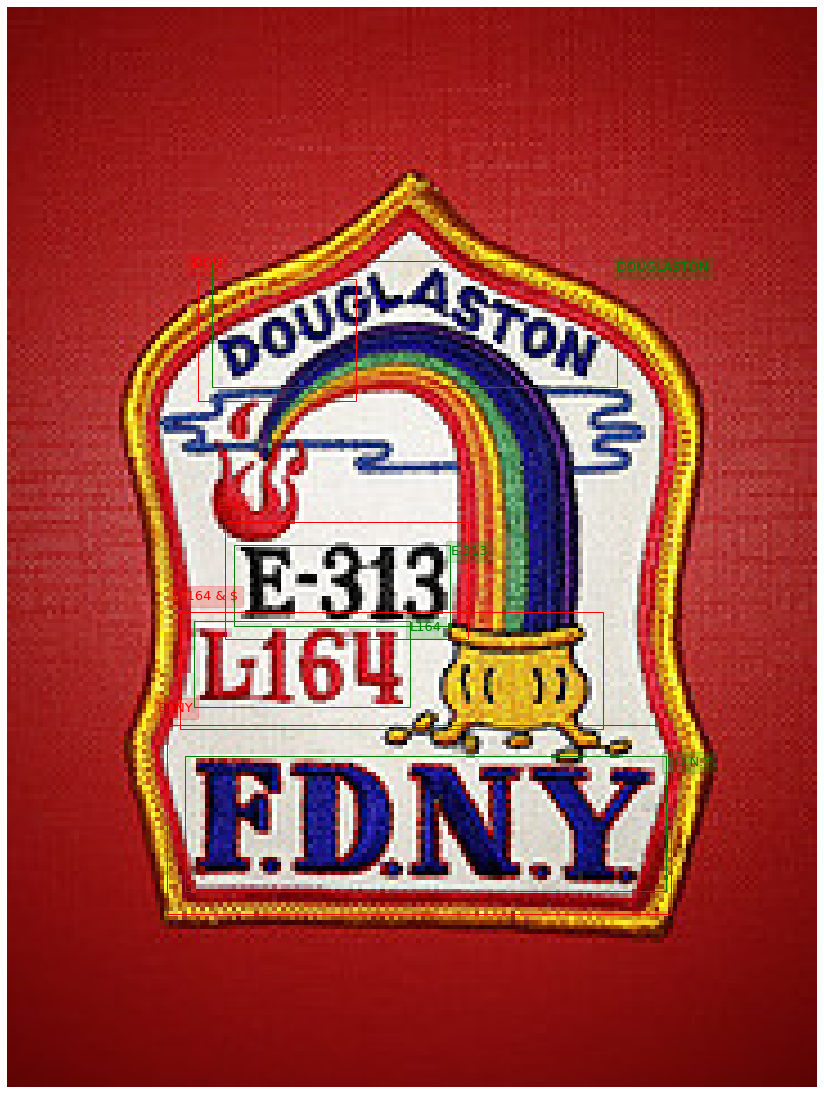

In [310]:
# all images / one sample image
# for i in range(len(images)):
i = 0

im = plot_results(images[i], ground_truth[i], predicted[i])  
im.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

im.savefig('%s/result_%s.png' % (output_dir, file_name))
im.show()
